In [2]:
import os
import pickle
import multiprocessing

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from collections import OrderedDict
import itertools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtrans
import seaborn as sns

import sys
sys.path.insert(1, '../cell2cell/')
import cell2cell as c2c
from cell2cell.tensor.tensor import BaseTensor
from cell2cell.tensor.factorization import _compute_norm_error

sys.path.insert(1, '../c2c_sim/')
from core.simulate import Simulate, CCI_MD


# specify path to save figures
fig_path = 'figures/example_figures/'#'/data2/hratch/cci_dt/figures/'
data_path = 'data/'#'/data2/hratch/cci_dt/noise_v_error/'
version = 1

# Generate Simulated Tensor

In [3]:
# # init
# sim = Simulate() 

# # simulate a scale_free randomly connected ligand-receptor network (potential interactions)
# sim.LR_network(network_type = 'scale-free', **{'nodes': 100, 'degrees': 3, 'alpha': 2}) #scale-free
# print('{} ligands, {} receptors, and {} edges'.format(len(sim.LR.ligands), len(sim.LR.receptors), 
#                                                       len(sim.LR.edge_list)))

# # LR metadata
# sim.LR.generate_metadata(n_LR_cats = {3: 0}, cat_skew = 0)

# # generate cell metadata, accounting for directionality (senders vs receivers) and 
# # allowing for autocrine interactions 
# cci = CCI_MD()
# cci.cci_network(n_cells = 50, directional = True, autocrine = True)

# # generate 1 metadata categories, with 3 subcategories and 0 skew, the overall skew of categories is 0
# # do not remove homotypic interactions (will be included)
# cci.generate_metadata(n_cell_cats = {3: 0}, cat_skew = 0, remove_homotypic = 0)
# # add cell metadata to simulation object
# sim.cci = cci

# # generate n_patter metadata groups of CC-LR pairs that change across n_conditions
# # these changes can either be linear, oscillating, or a pulse; allow homotypic interactions to form patterns
# # maximize the possible change in communication score
# sim.generate_tensor_md(n_patterns = 4, n_conditions = 12, patterns = ['pulse', 'linear', 'oscillate', 'power'], 
#                       consider_homotypic = True, score_change = 'max')

# #generate a tensor with continuous LR scores and baseline noise; keep single-cells 
# sim.generate_tensor(noise = 0.01, binary = False, bulk = True, noise_max = 0.05)

# # format the tensor to be input to tensor-cell2cell
# sim.reshape()
# sim.pickle(data_path + 'sim_obj_v' + str(version) + '.pickle') # save

with open(data_path + 'sim_obj_v' + str(version) + '.pickle', 'rb') as f:
    sim = pickle.load(f)
    
print(sim.sim_tensor.tensor_cci.shape)    

(12, 300, 3, 3)


In [5]:
# initialize c2c tensor obj
tensor = BaseTensor()
t1 = sim.sim_tensor.tensor_cci
tensor.tensor = t1
tensor.order_names = [['Context-{}'.format(c+1) for c in range(t1.shape[0])],
                      ['LR-{}'.format(c+1) for c in range(t1.shape[1])],
                      ['Sender-{}'.format(c+1) for c in range(t1.shape[2])],
                      ['Receiver-{}'.format(c+1) for c in range(t1.shape[3])]
                     ]

  0%|          | 0/10 [00:00<?, ?it/s]

(<Figure size 288x162 with 1 Axes>,
 [(1, 0.7715065964247386),
  (2, 0.5682070476296172),
  (3, 0.32628833921994993),
  (4, 0.009587732576599704),
  (5, 0.00958147502901061),
  (6, 0.009547856647817122),
  (7, 0.009552394158271978),
  (8, 0.009610663089166502),
  (9, 0.00960373279947829),
  (10, 0.009489756507318519)])

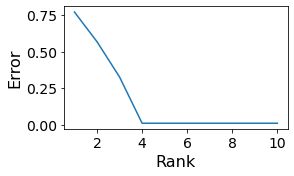

In [16]:
rs = 11 # set seed
tensor.elbow_rank_selection(int(sim.sim_tensor.rank*2.5), random_state = rs, 
                           filename = fig_path + 'sim_example_elbow.svg')

In [17]:
tensor.compute_tensor_factorization(rank = sim.sim_tensor.rank, random_state = rs)

In [18]:
# patterns df for visualization
res_pattern = pd.DataFrame(columns = ['score', 'cat', 'condition'])

for cond in sim.ts:
    for cat in sim.clrm.index:
        res_ = pd.DataFrame(columns = ['score', 'cat', 'condition'])
        res_['score'] = sim.ts[cond].values[sim.clrm.loc[cat,'ts_coordinates']]
        res_['cat'] = str(cat+1)
        res_['condition'] = cond
        res_pattern = pd.concat([res_pattern, res_], axis = 0)

res_pattern.reset_index(inplace = True, drop = True)
res_pattern['score'] = res_pattern['score'].astype(float)

cats = res_pattern.cat.unique().tolist()
cat_ordering = [str(int(j)) for j in sorted([int(i) for i in cats])]
res_pattern["cat"] = pd.Categorical(res_pattern["cat"], categories=cat_ordering) 
cond_ordering = [str(int(j)) for j in sorted([int(i) for i in res_pattern.condition.unique()])]
res_pattern["condition"] = pd.Categorical(res_pattern["condition"], categories=cond_ordering) 

<ipython-input-18-150ced8ac702>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res_['score'] = sim.ts[cond].values[sim.clrm.loc[cat,'ts_coordinates']]


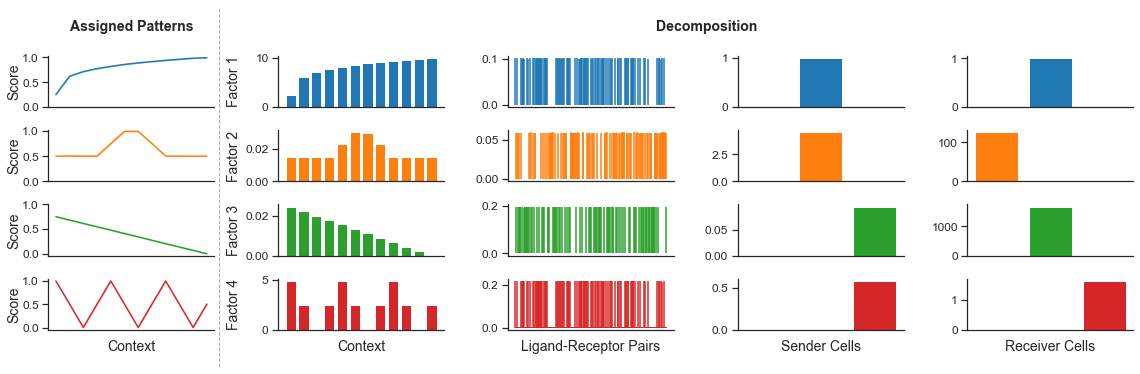

In [61]:
fontsize = 12
dim = len(tensor.factors)
rank = tensor.rank
colors = sns.color_palette("tab10")[:rank]
factors = OrderedDict((k, tensor.factors[k]) for k in ['Context', 'LRs', 'Sender', 'Receiver']) # reorder
order_labels = list(factors.keys())
olm = dict(zip(order_labels, 
              ['Context', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells']))
# Make the plot

fig, axes = plt.subplots(nrows=rank,ncols=dim+1,
                         figsize=(16, int((rank) * 1.2 + 1)), gridspec_kw={'width_ratios': [1,1,1,1,1]}) 

# from simulation values------------------------------------
counter = 0
for pattern in res_pattern.cat.unique():
    ax = axes[counter,0]
    viz_df = res_pattern[res_pattern.cat == pattern]
    sns.despine(top=True, ax=ax)
    sns.lineplot(data = viz_df, y = 'score', x = 'condition', color = colors[counter], 
             ax = ax)
    ax.set_ylabel('Score', labelpad = 1, fontsize=int(1.2*fontsize))
#     ax.yaxis.label.pad = 1
    ax.set_yticks([0,0.5,1])
    ax.set_xticks([])
#     ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='both', labelsize=fontsize)
    if counter == rank - 1:
        ax.set_xlabel('Context', fontsize=int(1.2*fontsize), labelpad = 10)
    else:
        ax.set_xlabel('')
    counter += 1
    
line = plt.Line2D((.195,.195),(0,1), color="darkgray", linewidth=1, linestyle = '--')
fig.add_artist(line) 

# from decomposition------------------------------
counter = 0
coords = list(itertools.product(range(rank), range(1,dim+1)))
for counter in range(len(coords)):
    coord = coords[counter]
    ax, dim_name, factor_name = axes[coord], order_labels[coord[1]-1], 'Factor ' + str(coord[0]+1)
    factor = factors[dim_name].iloc[:, coord[0]]
    sns.despine(top=True, ax=ax)

    if len(factor) < 50:
        ax.bar(range(len(factor)), factor.values.tolist(), color = colors[coord[0]])
    else: # issues with .bar width parameter
        ax.vlines(x = range(len(factor)), ymin = 0, ymax = factor.values.tolist(), color = colors[coord[0]])
    if coord[0] == rank-1:
        ax.set_xlabel(olm[dim_name], fontsize=int(1.2*fontsize), labelpad = 10)
    if (coord[1]-1) == 0:
        ax.set_ylabel(factor_name, fontsize=int(1.2*fontsize))
    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='both', labelsize=fontsize)
    plt.setp(ax.get_xticklabels(), visible=False)
fig.align_ylabels(axes[:,0])


#final formatting------------------------------------
axes[0,2].set_title('Decomposition', fontsize = fontsize + 2, pad = 25, fontweight = 'bold')
axes[0,2].title.set_position([1.2, 1.1])
axes[0,0].set_title('Assigned Patterns', fontsize = fontsize + 2, pad = 25, fontweight = 'bold')
    
fig.align_ylabels(axes[:,0])
fig.align_ylabels(axes[:,1])
fig.align_xlabels(axes[rank-1,:])

plt.tight_layout()
for ext in ['.png', '.pdf', '.svg']:
    plt.savefig(fig_path + 'sim_example' + ext, bbox_inches = 'tight')

# Accuracy

In [20]:
def get_jaccard(list1,list2):
    num = len(set(list1).intersection(list2))
    denom = len(set(list1).union(list2))
    return num/denom

In [21]:
lr_factors = tensor.tl_object.factors[1]

#### Jaccard

In [22]:
# get the IDs of the assigned LR pairs for each of the 4 patterns
assigned_lrs = dict()
senders = dict()
receivers = dict()
for idx in sim.clrm.index:
    pattern = sim.clrm.loc[idx, 'pattern']
    assigned = sim.clrm.loc[idx, ['cell_subcat', 'LR_subcat']]
    assigned_lrs[pattern] = sim.LR.LR_metadata[sim.LR.LR_metadata.subcategory == assigned.LR_subcat].LR_id.tolist()
    senders[pattern] = [assigned.cell_subcat[0]]
    receivers[pattern] = [assigned.cell_subcat[1]]
    
# binarize the LR loadings for each factor and get the LR IDs for those with 1 (high loadings)
decomposed_lrs = dict()
for factor in range(lr_factors.shape[1]):
    binarized_lr_loadings = pd.cut(lr_factors[:,factor], bins = 2, labels = [0,1]).tolist()
    decomposed_lrs[factor + 1] = [sim.sim_tensor.lr_labels[i] for i in range(len(binarized_lr_loadings)) if binarized_lr_loadings[i] == 1]

jaccards = pd.DataFrame(columns = ['factor - loadings', 'pattern - assigned', 'Jaccard index'])
counter = 0
for factor in decomposed_lrs:
    for pattern in assigned_lrs:
        jaccards.loc[counter, :] = [factor, pattern, get_jaccard(decomposed_lrs[factor], assigned_lrs[pattern])]
        counter += 1
jaccards['pattern - assigned'] = jaccards['pattern - assigned'].replace('power', 'exponential')
jaccards.to_csv(data_path + 'LR_Jaccard.csv')

In [23]:
lr_idx_map = {id_: idx for idx,id_ in enumerate(sim.sim_tensor.lr_labels)}
sender_idx_map = {id_: idx for idx,id_ in enumerate(sim.sim_tensor.senders)}
receiver_idx_map = {id_: idx for idx,id_ in enumerate(sim.sim_tensor.receivers)}

# assigned_lrs_idx = {k: [lr_idx_map[i] for i in v] for k,v in assigned_lrs.items()}
# senders_idx = {k: [sender_idx_map[i] for i in v] for k,v in senders.items()}
# receivers_idx = {k: [receiver_idx_map[i] for i in v] for k,v in receivers.items()}

In [24]:
res = pd.DataFrame(columns = ['factor', 'assigned_pattern', 'loadings', 'communication_score_variance', 
                             'communication_score'])
factor = 1
pattern = 'pulse'

for factor in range(lr_factors.shape[1]):
    for pattern in sim.clrm.pattern.unique():
        res_ = pd.DataFrame(data = {'loadings': lr_factors[:,factor]}, index = sim.sim_tensor.lr_labels)
        lr_idx = [lr_idx_map[i] for i in assigned_lrs[pattern]]
        sender_idx = [sender_idx_map[i] for i in senders[pattern]]
        receiver_idx = [receiver_idx_map[i] for i in receivers[pattern]]

        variances = list()
        scores = list()
        for lr_i in range((sim.sim_tensor.tensor_cci.shape[1])):#lr_idx:
            score = sim.sim_tensor.tensor_cci[:, lr_i,sender_idx,receiver_idx].flatten()
            scores.append(score)
            variances.append(np.var(score))
        res_['communication_score_variance'] = variances
        res_['factor'] = factor + 1
        res_['assigned_pattern'] = pattern
        res_['communication_score'] = scores

        res_ = res_[['factor', 'assigned_pattern', 'loadings', 'communication_score_variance', 
                    'communication_score']]
        res = pd.concat([res, res_])
res.replace('power', 'exponential', inplace = True)


/home/hratch/anaconda3/envs/cci_dt/lib/python3.9/site-packages/pandas/core/missing.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


#### Pearson

In [25]:
corr_stats = pd.DataFrame(columns = ['factor', 'assigned_pattern', 'Pearson r', 'p-value'])
counter = 0
for factor, pattern in itertools.product(res.factor.unique(), res.assigned_pattern.unique()):
    res_ = res[(res.factor == factor) & (res.assigned_pattern == pattern)]
    r = pearsonr(res_.loadings, res_.communication_score_variance)
    corr_stats.loc[counter,:] = [factor, pattern, r[0], r[1]]
    counter += 1
corr_stats.drop(columns = ['p-value'], inplace = True)
corr_stats['assigned_pattern'] = corr_stats['assigned_pattern'].replace('power', 'exponential')
corr_stats.to_csv(data_path + 'LR_Corr.csv')

#### Joint distribution: LOADINGS and PATTERNS  

In [26]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [27]:
# format dfs

# hard-coded, visual matching of decomposition and assigned patterns
factor_mapper = {1: 'exponential', 2: 'pulse', 3: 'linear', 4: 'oscillate'} 

corr_stats.factor = corr_stats.factor.astype(str)
corr_stats['pattern_pairs'] = corr_stats[['factor', 'assigned_pattern']].apply(lambda x: '-'.join(x), axis = 1)

jaccards['factor - loadings'] = jaccards['factor - loadings'].astype(str)
jaccards['pattern_pairs'] = jaccards[['factor - loadings', 'pattern - assigned']].replace('power', 'exponential').apply(lambda x: '-'.join(x), axis = 1)

res.factor = res.factor.astype(str)
res['pattern_pairs'] = res[['factor', 'assigned_pattern']].replace('power', 'exponential').apply(lambda x: '-'.join(x), axis = 1)
viz_df = res[res.pattern_pairs.isin([str(k) + '-' + v for k,v in factor_mapper.items()])]


In [56]:
%%capture
# plot jointplots of loadings vs patter communication score variance 
colors = sns.color_palette("tab10")[:4]
sns.set(style = 'ticks')

jointplot_map = list()
counter = 0
for pp in viz_df.pattern_pairs.unique():
    r_pearson = corr_stats[corr_stats.pattern_pairs == pp]['Pearson r'].values.tolist()[0]
    jaccard_val = jaccards[jaccards.pattern_pairs == pp]['Jaccard index'].values.tolist()[0]
    vdf_ = viz_df[viz_df.pattern_pairs == pp]

    g = sns.JointGrid(data = vdf_, y = 'loadings', x = 'communication_score_variance', 
                     marginal_ticks = True, space = 0.3)

    # marginal
    g = g.plot_marginals(sns.distplot, kde=False, color = colors[counter], bins = 25)

    g.ax_marg_x.set_yticks([0,100,200])
    g.ax_marg_x.yaxis.set_tick_params(rotation = 45, labelsize = 11, color = 'darkgray')
    g.ax_marg_x.yaxis.grid(linestyle = '--')

    g.ax_marg_y.set_xticks([0,100,200])
    g.ax_marg_y.xaxis.set_tick_params(rotation = 45, labelsize = 11, color = 'darkgray')
    g.ax_marg_y.xaxis.grid(linestyle = '--')
    g.ax_joint.xaxis.set_tick_params(labelsize = 12)

    # joint
    g = g.plot_joint(sns.regplot, scatter = False, color = colors[counter])
    g = g.plot_joint(plt.scatter, color = 'black')
    xlim, ylim = g.ax_joint.get_xlim(), g.ax_joint.get_ylim()
    intervalx, intervaly = g.ax_joint.get_xticks()[1], g.ax_joint.get_yticks()[1]


    g.ax_joint.annotate('Jaccard: {:.2f}'.format(jaccard_val), weight='bold',
                        xy = (0.675, 0.1), xycoords = 'axes fraction', fontsize = 13)
    g.ax_joint.annotate('Pearson r: {:.2f}'.format(r_pearson), weight='bold',
                        xy = (0.675, 0.05), xycoords = 'axes fraction', fontsize = 13)

    
    g.ax_joint.set_xlim(xlim[0]-(intervalx*0.3), xlim[1]+(intervalx*0.385)) 
    g.ax_joint.axhspan(ymin = np.median(g.ax_joint.get_yticks()), ymax = ylim[1]+(intervaly*0.3), 
                       xmin = (0.2*intervalx)/g.ax_joint.get_xlim()[1],
                       facecolor=colors[counter], alpha=0.1)
    
    
    if counter % 2 == 0:
        g.ax_joint.set_ylabel('LR ' + g.ax_joint.get_ylabel().capitalize(), fontsize = 14)
    else:
        g.ax_joint.set_ylabel('')
    if counter > (tensor.rank/2)-1:
        g.ax_joint.set_xlabel(' '.join([i.capitalize() for i in g.ax_joint.get_xlabel().split('_')]), fontsize = 14)
    else:
        g.ax_joint.set_xlabel('')
    counter += 1
    jointplot_map.append(g)


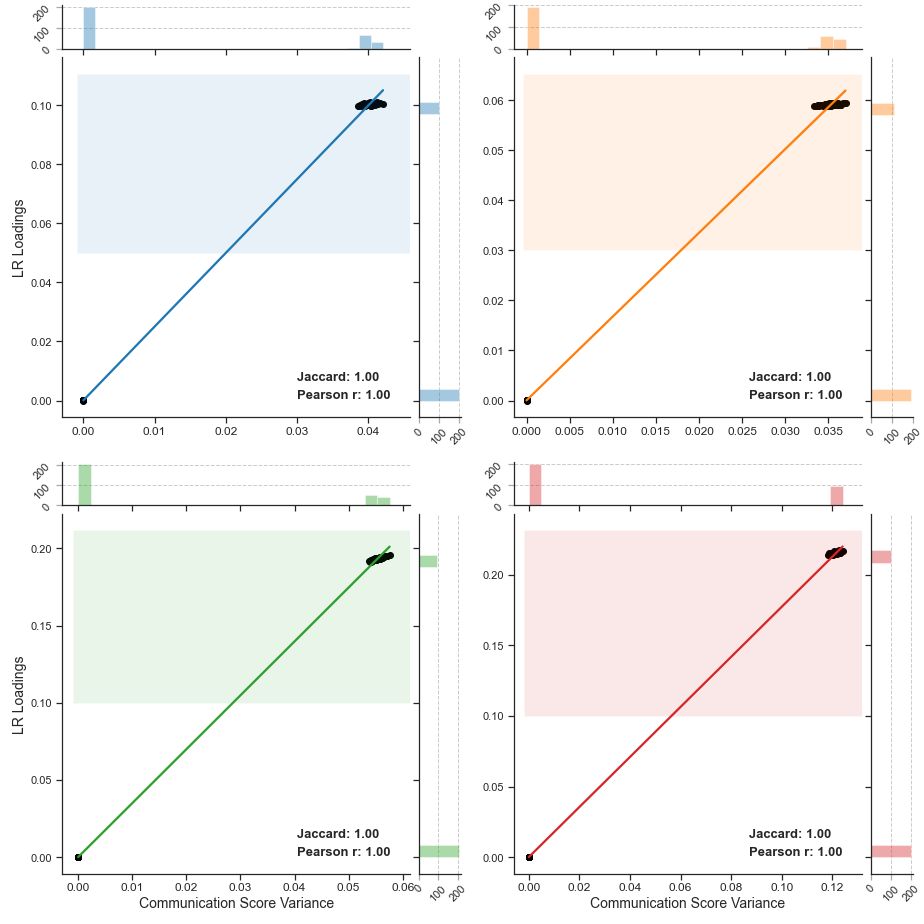

In [59]:
fig = plt.figure(figsize=(13,13))
gs = gridspec.GridSpec(2,2)

mg0 = SeabornFig2Grid(jointplot_map[0], fig, gs[0])
mg1 = SeabornFig2Grid(jointplot_map[1], fig, gs[1])
mg2 = SeabornFig2Grid(jointplot_map[2], fig, gs[2])
mg3 = SeabornFig2Grid(jointplot_map[3], fig, gs[3])

gs.tight_layout(fig)
for ext in ['.pdf', '.png', '.svg']:
    plt.savefig(fig_path + 'joint_loading_variance' + ext, bbox_inches = 'tight')